# 3 - Semi-variance Estimators

This tutorial focuses on experimental variograms. It will guide you through the main semi-variance estimators available in `scikit-gstat`. Additionally, most of the parameters available for building an experimental variogram will be discussed.

**In this tutorial you will learn:**

* what estimators are available
* how they differ

In [44]:
import skgstat as skg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

## 3.1 Load data

This tutorial will use the same data samples as the models tutorial. These are samples from the pancake image sampled at different sample sizes.
We will use only the second one, but you can re-run all the examples with any of the other fields.

In [45]:
s = [30, 80, 300]
data1 = skg.data.pancake(N=s[0], seed=42, as_dataframe=True).get('sample')
data2 = skg.data.pancake(N=s[1], seed=42, as_dataframe=True).get('sample')
data3 = skg.data.pancake(N=s[2], seed=42, as_dataframe=True).get('sample')

In [46]:
data2.values

array([[ 35, 429, 192],
       [ 85, 429, 194],
       [435, 248, 198],
       [493, 378, 182],
       [141, 485, 186],
       [329, 272, 219],
       [328, 371, 133],
       [110, 185, 131],
       [147, 411, 192],
       [114, 461, 198],
       [451, 162, 207],
       [ 29,  46, 218],
       [186, 219, 221],
       [231, 231, 188],
       [226, 113, 165],
       [458, 338, 101],
       [168, 233, 228],
       [298, 113, 207],
       [300,  82, 244],
       [452, 379, 131],
       [ 37,  47, 215],
       [373, 413, 125],
       [129, 273, 218],
       [322, 358, 139],
       [479,  64, 183],
       [ 58, 250, 203],
       [361, 483, 138],
       [120, 277, 211],
       [331, 221, 218],
       [274, 256, 164],
       [124, 282, 218],
       [ 48, 165, 137],
       [ 84,  38, 209],
       [ 92, 327, 200],
       [ 69, 225, 145],
       [384, 234, 211],
       [177, 372, 165],
       [154,  97, 167],
       [453, 334, 101],
       [ 20,  64, 209],
       [221, 216, 173],
       [ 83, 263

In [47]:
def plot_scatter(data, ax):
    art = ax.scatter(data.x, data.y, 50, c=data.v, cmap='plasma')
    plt.colorbar(art, ax=ax)

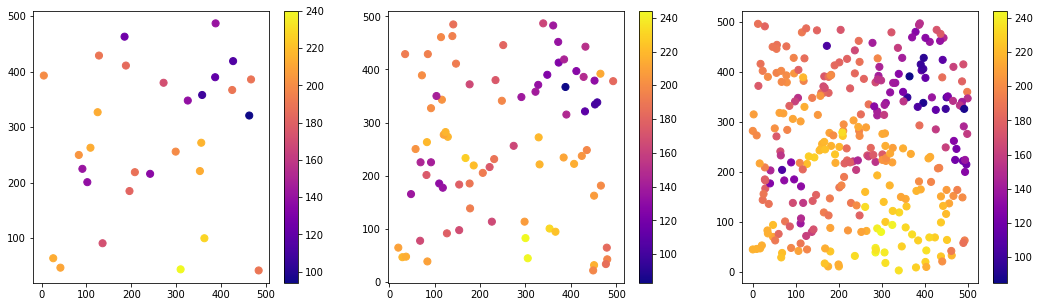

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for data, ax in zip((data1, data2, data3), axes.flatten()):
    plot_scatter(data, ax)

## 3.2 Comparing estimators

In [48]:
# calculate all variograms, but use only the second one

V1 = skg.Variogram(data2[['x', 'y']].values, data2.v.values, normalize=False, n_lags=8, use_nugget=True)
V2 = skg.Variogram(data2[['x', 'y']].values, data2.v.values, normalize=False, n_lags=15, use_nugget=True)
V3 = skg.Variogram(data2[['x', 'y']].values, data2.v.values, normalize=False, n_lags=25, use_nugget=True)

vario = V2

/Users/victorezekiel/Documents/experiments/extreme_exp/scikit-gstat/.venv/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/Users/victorezekiel/Documents/experiments/extreme_exp/scikit-gstat/.venv/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/victorezekiel/Documents/experiments/extreme_exp/scikit-gstat/.venv/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/Users/victorezekiel/Documents/experiments/extreme_exp/scikit-gstat/.venv/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/victorezekiel/Documents/experiments/extreme_exp/scikit-gstat/.venv/lib/python3.9/site-packages/

The default estimator configured in `Variogram` is the Mathéron estimator (Mathéron, 1963). It is defined like:


$$ \gamma (h) = \frac{1}{2N(h)} * \sum_{i=1}^{N(h)}(Z(x_i) - Z(x_{i+h}))^2 $$


where:

* $h$ is the distance lag
* $N(h)$ is the number of observation pairs in $h$-lag class
* $Z(x_i)$ is the observation at the $i$-th location $x$

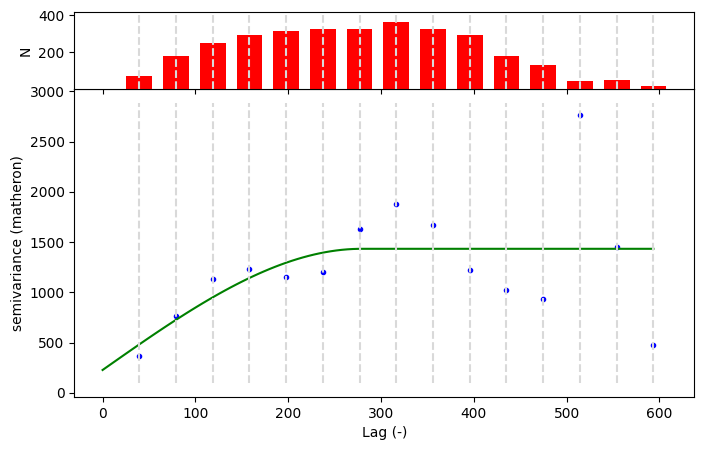

In [16]:
vario.plot(show=False);

Following the histogram, we should set a `maxlag`. This property accepts a number $0 < maxlag < 1$ to set the `maxlag` to this ratio of the maximum separating distance. A number > 1 will use this at an absolute limit. You can also pass `'mean'` or `'median'`. This will calculate and set the mean or median of all distances in the distance matrix as `maxlag`.

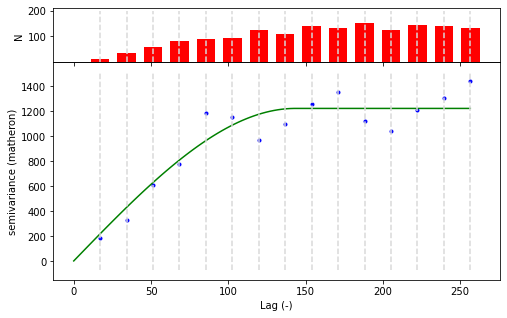

In [16]:
vario.maxlag = 'median'
vario.plot(show=False);

## 3.3 Alternative estimators

`scikit-gstat` implements more than only the Mathéron estimator. Setting `estimator='cressie'` will set the Cressie-Hawkins estimator. It is implemented as follows (Cressie and Hawkins, 1980):

$$ 2\gamma (h) = \frac{\left(\frac{1}{N(h)} \sum_{i=1}^{N(h)} |Z(x_i) - Z(x_{i+h})|^{0.5}\right)^4}
        {0.457 + \frac{0.494}{N(h)} + \frac{0.045}{N^2(h)}} $$

By setting `estimator='dowd'`, the Dowd estimator (Dowd, 1984) will be used:

$$ 2\gamma (h) = 2.198 * {median(Z(x_i) - Z(x_{i+h}))}^2 $$

Finally, `estimator='genton'` will set the Genton estimator (Genton, 1998):

$$ \gamma (h) = 2.2191\{|V_i(h) - V_j(h)|; i < j\}_{(k)} $$

with: 

$$ k = \binom{[N_h / 2] + 1}{2} $$

and:

$$ q = \binom{N_h}{2} $$


In [49]:
V = skg.Variogram(data2[['x', 'y']].values, data2.v.values, normalize=False, n_lags=25, use_nugget=True)

/Users/victorezekiel/Documents/experiments/extreme_exp/scikit-gstat/.venv/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:234: RuntimeWarning: divide by zero encountered in divide
  Delta = norm(x0 * scale_inv / v**0.5)
/Users/victorezekiel/Documents/experiments/extreme_exp/scikit-gstat/.venv/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar divide
  alpha *= Delta / Delta_new
/Users/victorezekiel/Documents/experiments/extreme_exp/scikit-gstat/.venv/lib/python3.9/site-packages/scipy/optimize/_lsq/common.py:49: RuntimeWarning: invalid value encountered in scalar divide
  t2 = c / q
/Users/victorezekiel/Documents/experiments/extreme_exp/scikit-gstat/.venv/lib/python3.9/site-packages/scipy/optimize/_lsq/trf.py:363: RuntimeWarning: invalid value encountered in scalar multiply
  alpha *= Delta / Delta_new
/Users/victorezekiel/Documents/experiments/extreme_exp/scikit-gstat/.venv/lib/python3.9/site-packages/scipy/optimize/_l

In [50]:
V.estimator = "madogram"

ValueError: Variogram estimator madogram is not understood, please provide the function.

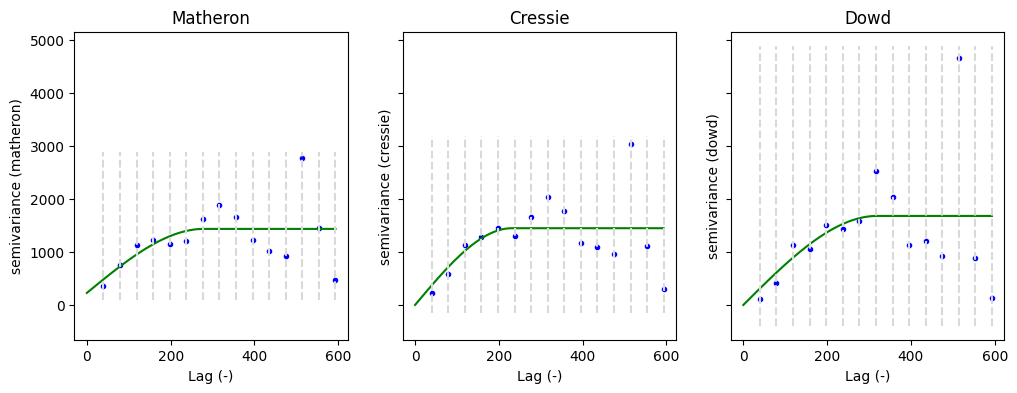

In [19]:
fig, _a = plt.subplots(1, 3, figsize=(12, 4), sharey=True)
axes = _a.flatten()
for ax, estimator_name in zip(axes, ('matheron', 'cressie', 'dowd', 'madogram')):
    vario.estimator = estimator_name
    vario.plot(axes=ax, hist=False, show=False)
    ax.set_title(estimator_name.capitalize())

The important part is here that the effective range as well as the sill is changeing for the estimator. This will likely change the Kriging result.
For Kriging, the difference on the first few lag classes is important, as no points will be used for estimation, that lies outside the range. We will zoom in, to actually use a higher resolution. Thus the results will be quite smooth.

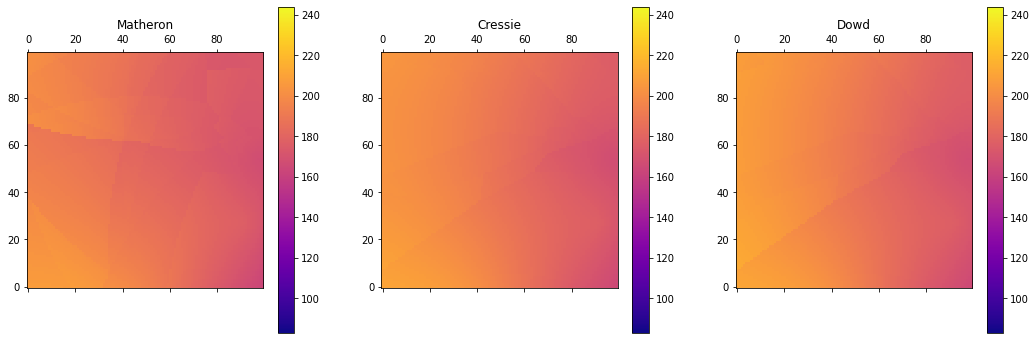

In [68]:
xx, yy = np.mgrid[100:199:100j, 0:99:100j]
fig, _a = plt.subplots(1, 3, figsize=(18, 6))
axes = _a.flatten()

fields = []
for ax, est in zip(axes, ('matheron', 'cressie', 'dowd')):
    vario.estimator = est
    ok = skg.OrdinaryKriging(vario, min_points=5, max_points=15, mode='exact')
    field = ok.transform(xx.flatten(), yy.flatten()).reshape(xx.shape)
    fields.append(field)
    art = ax.matshow(field, origin='lower', cmap='plasma', vmin=vario.values.min(), vmax=vario.values.max())
    plt.colorbar(art, ax=ax)
    ax.set_title(est.capitalize())

It's hard to see this by eye, but there are actually some differences. Let's load the original field as well and see which estimator performed best.

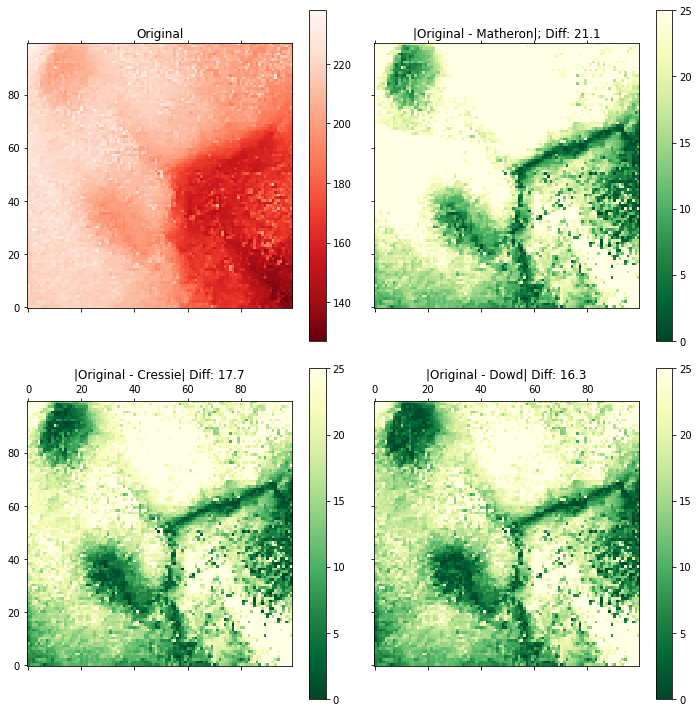

In [69]:
pan = skg.data.pancake_field().get('sample')

# rescale to 100x100
# pan = zoom(pan, 0.2)
# select the same extend
pan = pan[100:200, 0:100]

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

# original
m = axes[0][0].matshow(pan, origin='lower', cmap='Reds_r')
plt.colorbar(m, ax=axes[0][0])
axes[0][0].set_title('Original')

# matheron
m = axes[0][1].matshow(np.abs(pan - fields[0]), origin='lower', cmap='YlGn_r', vmin=0, vmax=25)
plt.colorbar(m, ax=axes[0][1])
axes[0][1].set_title(f'|Original - Matheron|; Diff: {np.abs(pan - fields[0]).mean().round(1)}')

# cressie
m = axes[1][0].matshow(np.abs(pan - fields[1]), origin='lower', cmap='YlGn_r', vmin=0, vmax=25)
plt.colorbar(m, ax=axes[1][0])
axes[1][0].set_title(f'|Original - Cressie| Diff: {np.abs(pan - fields[1]).mean().round(1)}')

# dowd
m = axes[1][1].matshow(np.abs(pan - fields[2]), origin='lower', cmap='YlGn_r', vmin=0, vmax=25)
plt.colorbar(m, ax=axes[1][1])
axes[1][1].set_title(f'|Original - Dowd| Diff: {np.abs(pan - fields[2]).mean().round(1)}')


plt.tight_layout()

In the extracted part of the field, quite some differences are visible. The Matheron estimator is less robust and can't capture the higher values in the upper left corner not as quite well as the other estimators. One can also see, that a substantial amount of the deviations are caused by the noisy character of the original image. Note that we loaded the field without applying any kind of filter to it. 

## 3.4 References

Cressie, N., and D. Hawkins (1980): Robust estimation of the variogram. Math. Geol., 12, 115-125.

Dowd, P. A., (1984): The variogram and kriging: Robust and resistant estimators, in Geostatistics for Natural Resources Characterization. Edited by G. Verly et al., pp. 91 - 106, D. Reidel, Dordrecht.

Genton, M. G., (1998): Highly robust variogram estimation, Math. Geol., 30, 213 - 221.

Matheron, G. (1963). Principles of geostatistics. Economic Geology, 58(8), 1246–1266. https://doi.org/10.2113/gsecongeo.58.8.1246